## Load Datasets

In [1]:
import pandas as pd
import os, re

path = '..\\data'
filenames = [
    'data-cityofnewyork-us.bty7-2jhb.csv',
    'data-cityofnewyork-us.ptev-4hud.csv',
    'data-cityofnewyork-us.un8d-rbed.csv',
    'data-cityofnewyork-us.wye7-nyek.csv',
]
columns = [
    'Job Start Date',
    'Start Date',
    'Start Date',
    'Permit Start Date',
]
# pandas Series of Start Dates columns
dates = []
for filename, col in zip(filenames, columns):
    df = pd.read_csv(os.path.join(path, filename), usecols=[col])
    dates.append(df[col])
print('Total # of rows: ', sum(col.size for col in dates))

Total # of rows:  2865919


## Date

### Column Introduction

Date related columns are very common and may exist in the vast majority of datasets. However, in this project we need to find the columns that may overlap with the original dataset. Therefore, we used the similarity method described above to find columns with similar names to the column "Agenda Start Date" in the original dataset.

### Our original strategy

In the original dataset, the string format of the column "Agency Start Date" is already standardized. Their years, months and days are separated by a slash character, that is to say, they follow the `"%m/%d/%Y"` datetime format. Therefore, the data processing for this column is quite simple, we would just split the string by the slash character to get the corresponding year, month and day. It turns out that values of years are more important than others, so our original strategy would mainly focus on them.

- First, we deleted the null values.
- Second, we split each string by slash character `"/"`. Because it follows `"%m/%d/%Y"` datetime format, the third string should be year.
- We simply deleted all the values with years greater than 2021.
- Also, we used common sense to consider some years such as 1901 as outliers.

### Result of effectiveness and problems in new datasets

When our original strategy was applied only to the original dataset, the results were seemed to be good and there was no problem with precision. Unfortunately, our original strategy actually has major problems, especially when we try to apply it to other datasets. In fact, our original strategy was simple and crude and not extensible at all. It is easy to identify many of the problems in data cleaning strategy described above:

- When parsing datetime-like strings, apparently we should not just split the year, month and day by a certain kind of delimiter. For example, the string `"13/41/2020"` is not a valid datetime, but it is impossible to validate by just splitting the string. Usually we should use the datetime-related methods in python module, passing in a datetime format string to parse and validate.
- Further more, there may be different datetime formats in a single dataset, which may require us to use several different formats to parse.
- It is completely wrong to delete all data greater than the current year because it does not take into account the meaning of column names at all. "Start Date" may have years greater than current year, of course. More inspection is needed.

We inspected new datasets "bty7-2jhb.csv", "ptev-4hud.csv", "un8d-rbed.csv", "wye7-nyek.csv" and noticed that dataset "bty7-2jhb.csv" had pretty chaotic format.

### Apply our refined strategy

Our refined strategy consists of following steps:

- Try to parse datetime-like strings with more than 1 formats. For example, in this project we parsed with both `"%m/%d/%Y"` and `"%Y-%m-%dT%H:%M:%S"`.
- During parsing, we will find out the invalid strings, try to extract the year, month and day, then generate figures by visualization method. (**Figure 1**)
- In order to identify outliers, we draw histograms for all years (**Figure 2**), as well as histograms for years equal or less than the current year (**Figure 3**) for comparison.
- If we still cannot confidently identify the outliers, then apply clustering algorithms such as DBSCAN to cluster the possible outliers. (**Figure 4**)

Our strategy found 29 rows of invalid strings out of the total 2865919 rows. There are 199 rows with a year greater than the current year. But by analyzing the clustering results, we decided to define the 167 rows that greater than year 2033 as outliers.

In [2]:
dates[1:] = [pd.to_datetime(col, format=r'%m/%d/%Y') for col in dates[1:]]

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

def draw_histogram(ax, x, name, color, b_size, y_log=True):
    ax.set_xlabel(f'values: {name}', fontsize=12)
    if y_log: 
        ax.set_yscale('log', base = 10)
        ax.set_ylabel('count (log)', fontsize=12)
    else:
        ax.set_ylabel('count', fontsize=12)
    _ = ax.hist(x, bins=b_size, color=color)

In [4]:
malformed_col = dates[0]
# convert by date format
# objects that don't conform to this format will be set to NaT
converted_col = pd.to_datetime(malformed_col, format=r'%Y-%m-%dT%H:%M:%S', errors='coerce')
error_index = converted_col.isna()
# original objects that have the wrong format
error_dates = malformed_col[error_index]
# if original object is NaN, then it's not an error
error_dates.dropna(inplace=True)
print('# of rows contain error format:', error_dates.size)
# clean error rows
converted_col.drop(error_dates.index, inplace=True)
dates[0] = converted_col

# of rows contain error format: 29


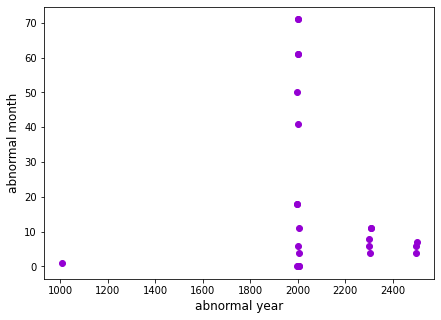

In [5]:
def draw_error_years_months(data: pd.Series):
    x_years = []
    y_months = []
    for s in data:
        matched = re.search(r'(\d+)-(\d+)-(\d+)', s)
        if matched is not None:
            x_years.append(int(matched[1]))
            y_months.append(int(matched[2]))
            continue
        matched = re.search(r'(\d+)/(\d+)/(\d+)', s)
        if matched is not None:
            x_years.append(int(matched[3]))
            y_months.append(int(matched[1]))
            continue
    fig, ax = plt.subplots(1, 1, figsize=(7,5))
    ax.set_xlabel('abnormal year', fontsize=12)
    ax.set_ylabel('abnormal month', fontsize=12)
    ax.scatter(x_years, y_months, color='darkviolet')

draw_error_years_months(error_dates)
# Figure 1: Visualisation of malformed datetimes obtained by data cleaning

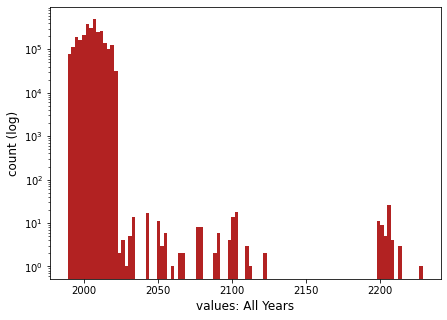

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(7,5))
years = pd.concat(col.dt.year for col in dates).dropna().astype('int32')
draw_histogram(ax, years, 'All Years', 'firebrick', 100, True)
# Figure 2: Histogram of value count for all years

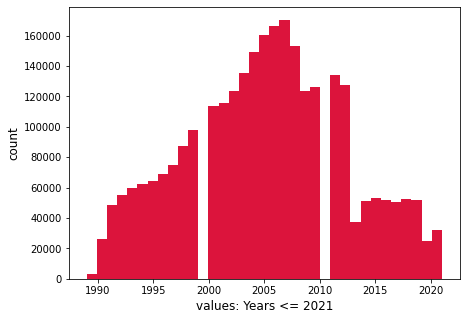

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(7,5))
draw_histogram(ax, years[years <= 2021], 'Years <= 2021', 'crimson', 35, False)
# Figure 3: Histogram of value count for years <= 2021

# of rows which year > 2021: 199


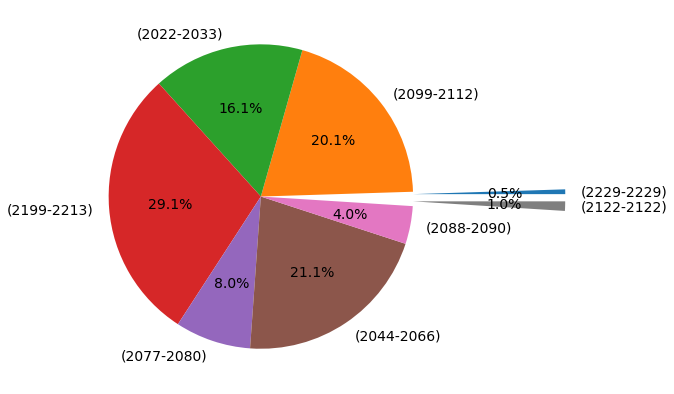

In [11]:
import numpy as np
from sklearn.cluster import DBSCAN

x = years.to_numpy()
# get abnormal years greater than 2021
x = x[x > 2021].reshape(-1, 1)
print('# of rows which year > 2021:', x.shape[0])
clusters = DBSCAN(eps=7, min_samples=2).fit(x)

def draw_clusters_pie(ax, x, clusters):
    x = x.reshape(-1)
    sizes = []
    explode = []
    plot_labels = []
    for i in np.unique(clusters.labels_):
        same_labels = x[clusters.labels_ == i]
        sizes.append(same_labels.shape[0]/ x.shape[0])
        explode.append(sizes[-1] < 0.02)
        plot_labels.append(f'({same_labels.min()}-{same_labels.max()})')
    ax.pie(sizes, explode=explode, labels=plot_labels, autopct='%1.1f%%', textprops={'fontsize': 14})


fig, ax = plt.subplots(1, 1, figsize=(7,7))
fig.set_facecolor('white')
draw_clusters_pie(ax, x, clusters)
# Figure 4: Clustering result for possible abnormal years obtained by data cleaning

In [9]:
print('# of rows which year > 2033:', x[x > 2033].shape[0])

# of rows which year > 2033: 167


## Extend to all the datasets

The more datasets we process, the more date string formats we may encounter. Therefore, the extended strategy needs to be able to detect a variety of different formats and parse them correctly.

## Conclusion

The focus of datetime-related data cleaning is on parsing strings and detecting invalid formats. Other than that, defining outliers is not difficult.

## Limitation and challenges

See Conclusion